This Notebook includes the following tasks:

1. Load reviews
2. Exploratory data analysis
3. Hyphothesis testing with permutation analysis
4. Cleaning, tokenization, and Sentiment analysis with Logistic regression
5. Sentiment analyis with Convolutional neural network
    *  Convolutional network
    *  LSTM network


## Load modules and data

In [1]:
!pip install eli5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib
import eli5

In [5]:
with open('train.ft.txt') as f:
  train_x=[line[11:] for line in f.readlines()]
with open('train.ft.txt') as f: # label 1 means 1-2 reviews and 0 means 4-5 reviews. Neutral(3) reviews have been removed from the data
  train_y=[1 if line[:11]=="__label__1 " else 0 for line in f.readlines()]
with open('test.ft.txt') as f:
  test_x=[line[11:] for line in f.readlines()]
with open('test.ft.txt') as f:
  test_y=[1 if line[:11]=="__label__1 " else 0 for line in f.readlines()]

train=pd.DataFrame({'review':train_x,'label_num':train_y})
test=pd.DataFrame({'review':test_x,'label_num':test_y})

del train_x
del test_x
del train_y
del test_y

train.head()

,review,label_num
0,Stuning even for the non-gamer: This sound tra...,0
1,The best soundtrack ever to anything.: I'm rea...,0
2,Amazing!: This soundtrack is my favorite music...,0
3,Excellent Soundtrack: I truly like this soundt...,0
4,"Remember, Pull Your Jaw Off The Floor After He...",0


## Simple EDA

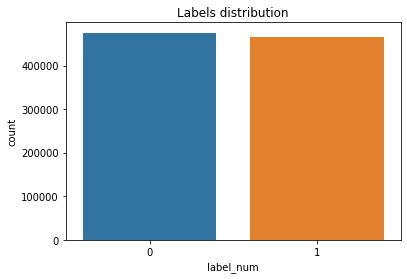

In [ ]:
sns.countplot(train['label_num']);
plt.title('Labels distribution');

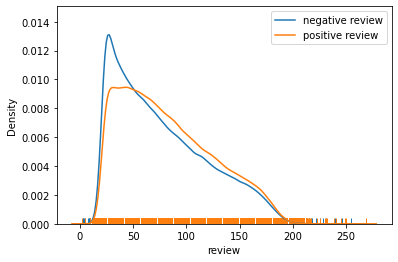

In [ ]:
sns.distplot(train[train['label_num']==0]['review'].apply(lambda x: len(x.split())),label='negative review', hist=False, rug=True)
sns.distplot(train[train['label_num']==1]['review'].apply(lambda x: len(x.split())),label='positive review', hist=False, rug=True)
plt.legend()
plt.show()


 We can carry out a simple statistical test to see if happy reviews are longer on average than unhappy feedbacks. To do this, we first visualize boxplot of review length for both classes. We then do permutation testing for  $pos\_mean\_len-neg\_mean\_len\geq observed\_dif$ and we compute the probability of getting at least the observed difference in mean under the hypothesis that the distributions of words are identical.. 

Negative mean length: 76.43
Positive mean length: 82.44
Mean Difference: 6.01


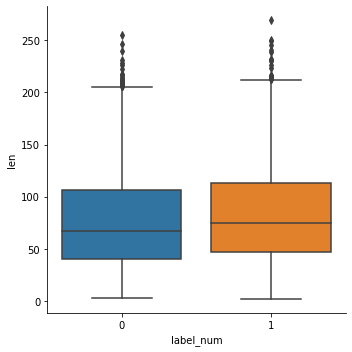

In [ ]:
neg_mean_len = np.mean(train[train['label_num']==0]['review'].apply(lambda x: len(x.split())))
pos_mean_len = np.mean(train[train['label_num']==1]['review'].apply(lambda x: len(x.split())))

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {pos_mean_len-neg_mean_len:.2f}")

data=train.copy()
data['len']=train['review'].apply(lambda x: len(x.split()))
ax = sns.catplot(x='label_num', y='len', data=data, kind='box')

## Hyphothesis testing
Here we are testing whether positive tweets are longer than the negative tweets on average.

In [ ]:
neg_array = data[data['label_num']==0]['len'].values
pos_array = data[data['label_num']==1]['len'].values
mean_diff = pos_mean_len-neg_mean_len 

In [ ]:
def draw_perm_reps(data_1, data_2, n=1,mean_diff=mean_diff):
  """
  Replicates the permutation statistic with positive and negative review length samples n times
  """
  def permutation_sample(data_1, data2):
    permuted = np.random.permutation(np.concatenate((data_1,data_2)))    # Permute the concatenated array
    sample_1, sample_2 = permuted[:len(data_2)], permuted[len(data_2):]  # get permuated samples with same sizes as originals
    return sample_1, sample_2

  perm_iters = np.zeros(n)
  for i in range(n):
      sample_1, sample_2 = permutation_sample(data_1, data_2)         # Generate permutation sample
      perm_iters[i] = np.mean(sample_1) - np.mean(sample_2)           # Compute the test statistic
  p = np.sum(perm_iters >= mean_diff) / len(perm_iters)               # perform the test and calculate p-value
  if p<0.05: print(" \n There is a significant difference between length of positive and negative with {}% confidence".format(100*(1-p)))
  return 

In [ ]:
draw_perm_reps(neg_array,pos_array,n=100)

 
 There is a significant difference between length of positive and negative with 100.0% confidence


# Logistic model

In [6]:
transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2),
                              lowercase=True,max_features=100000)
train_x = transformer.fit_transform(train['review'])
test_x = transformer.transform(test['review'])

train_y = train.label_num
test_y = test.label_num


In [7]:
def prediction(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)
    report=classification_report(y_valid, pred)
    joblib.dump(model, f"model_acc_{acc:.5f}.pkl")
    return model, acc, f1, report

In [8]:
model = LogisticRegression(C=1, random_state=42, n_jobs=-1)
fit_model, acc, f1, report = prediction(model, train_x, train_y, test_x, test_y)

print(f"Accuracy: {acc:.5f}")
print(f"F1_Score: {f1:.5f}")
print(f"Confusion Matrix: {report}")


Accuracy: 0.91080
F1_Score: 0.91041
Confusion Matrix:               precision    recall  f1-score   support

           0       0.91      0.92      0.91    200000
           1       0.91      0.91      0.91    200000

    accuracy                           0.91    400000
   macro avg       0.91      0.91      0.91    400000
weighted avg       0.91      0.91      0.91    400000



In [9]:
eli5.show_weights(estimator=fit_model, 
                  feature_names= list(transformer.get_feature_names()),
                    top=(20,20))

Weight?,Feature
+19.139,disappointing
+18.366,worst
+15.559,disappointment
+15.043,disappointed
+14.474,boring
+14.234,waste
+13.219,terrible
+12.574,poor
+12.476,horrible
+12.454,awful


# Neural Net

## Convolutional network 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

In [ ]:
train_labels, train_texts = train['label_num'].values , train['review'].values
test_labels, test_texts = test['label_num'].values , test['review'].values

# del model
# del transformer
# del train_x
# del test_x
# del train_y
# del test_y
del train
del test

In [ ]:
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

In [ ]:
MAX_FEATURES = 15000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In [ ]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

In [ ]:
def build_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.Conv1D(64, 3, activation='relu')(embedded)
    x = tensorflow.keras.layers.BatchNormalization()(x)
    x = layers.MaxPool1D(3)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model
conv_model = build_model()


In [ ]:
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 241)]             0         
                                                                 
 embedding (Embedding)       (None, 241, 64)           960000    
                                                                 
 conv1d (Conv1D)             (None, 239, 64)           12352     
                                                                 
 batch_normalization (BatchN  (None, 239, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 79, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 75, 64)            20544 

In [ ]:
conv_model.fit(
    train_texts, 
    train_labels, 
    batch_size=256,
    epochs=2,
    validation_data=(test_texts, test_labels), )

Epoch 1/2
3244/3244 [==============================] - 61s 15ms/step - loss: 0.2041 - binary_accuracy: 0.9179 - val_loss: 0.1684 - val_binary_accuracy: 0.9356
Epoch 2/2
3244/3244 [==============================] - 49s 15ms/step - loss: 0.1458 - binary_accuracy: 0.9456 - val_loss: 0.1664 - val_binary_accuracy: 0.9371


In [ ]:
from sklearn.metrics import classification_report
conv_preds = conv_model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (conv_preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (conv_preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, conv_preds)))
print(classification_report(test_labels,1 * (conv_preds > 0.5)))

Accuracy score: 0.9371
F1 score: 0.9359
ROC AUC score: 0.984
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    200000
           1       0.96      0.92      0.94    200000

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000



#LSTM model

In [ ]:
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional
def build_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units =256, return_sequences= True)(embedded)
    # Add dropout with a probability of 0.5
    X = Dropout(rate=0.7)(X) 
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units = 128, return_sequences= False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate=0.5)(X)
    x = layers.Dense(100, activation='relu')(X)
    x = layers.Dense(30, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)    
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model
lstm_model = build_model()
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 241)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 241, 64)           960000    
                                                                 
 lstm_2 (LSTM)               (None, 241, 256)          328704    
                                                                 
 dropout_2 (Dropout)         (None, 241, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               1290

In [ ]:
lstm_model.fit(
    train_texts, 
    train_labels, 
    batch_size=128,
    epochs=2,
    validation_data=(test_texts, test_labels))

Epoch 1/2
6488/6488 [==============================] - 426s 65ms/step - loss: 0.2164 - binary_accuracy: 0.9153 - val_loss: 0.1662 - val_binary_accuracy: 0.9378
Epoch 2/2
6488/6488 [==============================] - 422s 65ms/step - loss: 0.1543 - binary_accuracy: 0.9428 - val_loss: 0.1555 - val_binary_accuracy: 0.9409


In [ ]:
from sklearn.metrics import classification_report
lstm_preds = lstm_model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (lstm_preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (lstm_preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, lstm_preds)))
print(classification_report(test_labels,1 * (lstm_preds > 0.5)))

Accuracy score: 0.9429
F1 score: 0.9429
ROC AUC score: 0.9853
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    200000
           1       0.94      0.94      0.94    200000

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000

